In [1]:
# Inspired by https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Configuration
batch_size = 20
# Dimension of the embedding vector. Two too small to get
# any meaningful embeddings, but let's make it 2 for simple visualization
embedding_size = 2
num_sampled = 15    # Number of negative examples to sample.

# Sample sentences
sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]

# sentences to words and count
words = " ".join(sentences).split()
count = collections.Counter(words).most_common()
print ("Word count", count[:5])

('Word count', [('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3)])


In [3]:
# Build dictionaries
rdic = [i[0] for i in count] #reverse dic, idx -> word
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id
voc_size = len(dic)

# Make indexed word data
data = [dic[word] for word in words]
print('Sample data', data[:10], [rdic[t] for t in data[:10]])

('Sample data', [8, 33, 24, 20, 17, 12, 8, 25, 30, 26], ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I'])


In [4]:
# Let's make a training data for window size 1 for simplicity
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...
cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
print('Context pairs', cbow_pairs[:10])

('Context pairs', [[[8, 24], 33], [[33, 20], 24], [[24, 17], 20], [[20, 12], 17], [[17, 8], 12], [[12, 25], 8], [[8, 30], 25], [[25, 26], 30], [[30, 4], 26], [[26, 0], 4]])


In [5]:
# Let's make skip-gram pairs
# (quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
print('skip-gram pairs', skip_gram_pairs[:5])

('skip-gram pairs', [[33, 8], [33, 24], [24, 33], [24, 20], [20, 24]])


In [6]:
def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

# generate_batch test
print ('Batches (x, y)', generate_batch(3))

('Batches (x, y)', ([10, 2, 15], [[4], [1], [16]]))


In [7]:
# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, voc_size))
# Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

In [8]:
# Launch the graph in a session
with tf.Session() as sess:
    # Initializing all variables
    tf.global_variables_initializer().run()

    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        if step % 10 == 0:
          print("Loss at ", step, loss_val) # Report the loss

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()



('Loss at ', 0, 17.144363)
('Loss at ', 10, 15.990053)
('Loss at ', 20, 6.7392898)
('Loss at ', 30, 4.1302481)
('Loss at ', 40, 3.964936)
('Loss at ', 50, 3.7568462)
('Loss at ', 60, 3.9899201)
('Loss at ', 70, 3.3476052)
('Loss at ', 80, 3.2176445)
('Loss at ', 90, 3.3145294)


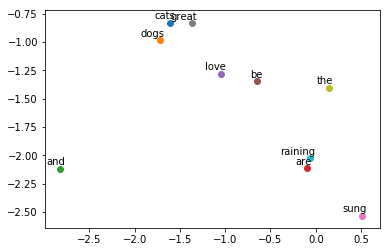

In [9]:
# Show word2vec if dim is 2
if trained_embeddings.shape[1] == 2:
    labels = rdic[:10] # Show top 10 words
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.savefig("word2vec.png")